<a href="https://colab.research.google.com/github/Eduzc07/machinelearning/blob/master/2_Finance/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()

# **Trading Strategies**

Hi


In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [3]:
## Save future files to your drive
## In this notebook control for multiple testing
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/Data/Agent Trading"

Mounted at /content/drive
/content/drive/My Drive/Data/Agent Trading


In [408]:
from pandas_datareader import data as pdr
import os.path
import fix_yahoo_finance as yf

name = 'AAPL'
nameFile = 'output/%s.csv'%name
bForce = False #Change to true to force update

if os.path.isfile(nameFile) and not bForce:
  print('%s already exist. It will be read.'%name)
  # Read file if it has been saved
  df_full = pd.read_csv(nameFile)
else:
  yf.pdr_override()
  df_full = pdr.get_data_yahoo("AAPL", start="2014-01-01").reset_index()
  df_full.to_csv('output/AAPL.csv', index=False)

# Converts string to datetime
df_full['Date'] = pd.to_datetime(df_full.Date, format='%Y-%m-%d')
# Set the index of dataframe to date column
df_full = df_full.set_index('Date')

df_full.head()

AAPL already exist. It will be read.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,79.382858,79.575714,78.860001,79.018570,71.320679,58671200
2014-01-03,78.980003,79.099998,77.204285,77.282860,69.754066,98116900
2014-01-06,76.778572,78.114288,76.228569,77.704285,70.134438,103152700
2014-01-07,77.760002,77.994286,76.845711,77.148575,69.632866,79302300
2014-01-08,76.972855,77.937141,76.955711,77.637146,70.073868,64632400


In [309]:
df_full.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-29,208.500000,209.320007,206.660004,209.009995,209.009995,20990500
2019-08-30,210.160004,210.449997,207.199997,208.740005,208.740005,21143400
2019-09-03,206.429993,206.979996,204.220001,205.699997,205.699997,20023000
2019-09-04,208.389999,209.479996,207.320007,209.190002,209.190002,19188100
2019-09-05,212.000000,213.960007,211.869995,212.559998,212.559998,11662947


Rolling Mean (Moving Average) 

In [365]:
close_px = df_full['Adj Close']
mavg = close_px.rolling(window=100).mean()

close_px.head()

Date
2014-01-02    71.320679
2014-01-03    69.754066
2014-01-06    70.134438
2014-01-07    69.632866
2014-01-08    70.073868
Name: Adj Close, dtype: float64

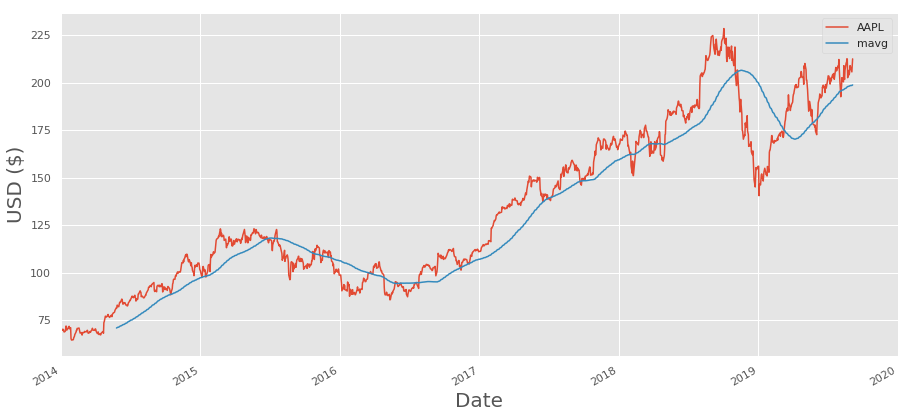

In [366]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

#Create fig to plot
fig, ax = plt.subplots()

# plt.plot(df_full['Date'], close_px, label='AAPL')
# plt.plot(df_full['Date'], mavg, label='mavg')

plt.plot(close_px, label='AAPL')
plt.plot(mavg, label='mavg')
plt.legend()
plt.xlabel('Date', fontsize = 20)
plt.ylabel('USD ($)', fontsize = 20)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(df_full.index.min(), 'Y')
datemax = np.datetime64(df_full.index.max(), 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

#format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#ax.grid(True)

fig.autofmt_xdate()
plt.show()

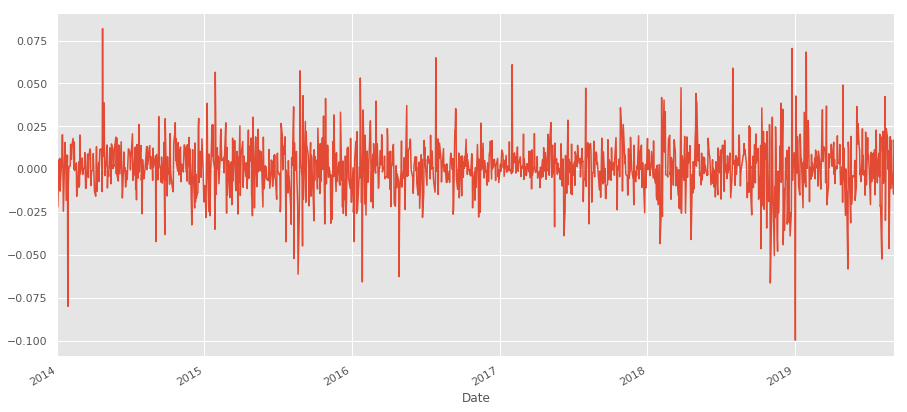

In [299]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Predicting Stocks Price

In [447]:
dfreg = df_full.loc[:,['Adj Close','Volume']]
#High Low Percentage
dfreg['HL_PCT'] = (df_full['High'] - df_full['Low']) / df_full['Close'] * 100.0
#Percentage Change
dfreg['PCT_change'] = (df_full['Close'] - df_full['Open']) / df_full['Open'] * 100.0

dfreg.head(10)

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2014-01-02,71.320679,58671200,0.905753,-0.458900
2014-01-03,69.754066,98116900,2.452954,-2.148826
2014-01-06,70.134438,103152700,2.426789,1.205692
2014-01-07,69.632866,79302300,1.488783,-0.786300
2014-01-08,70.073868,64632400,1.264124,0.863020
2014-01-09,69.179001,69787200,2.145308,-1.880032
2014-01-10,68.717400,76244000,1.818215,-1.276324
2014-01-13,69.077148,94623200,2.355663,1.098300
2014-01-14,70.451653,83140400,1.659987,1.517968


In [448]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

X_data = np.array(dfreg.drop(['label'], 1))

dfreg.tail(20)

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2019-08-08,202.659988,27009500,2.035098,1.613385,209.009995
2019-08-09,200.990005,24619700,1.726455,-0.153998,208.740005
2019-08-12,200.479996,22474900,1.446533,0.430819,205.699997
2019-08-13,208.970001,47218500,5.579750,3.954829,209.190002
2019-08-14,202.750000,36547400,1.898893,-0.201813,212.559998
2019-08-15,201.740005,27227400,2.711411,-0.845376,NaN
2019-08-16,206.500000,27620400,1.607752,1.086744,NaN
2019-08-19,210.350006,24413600,1.283574,-0.128188,NaN
2019-08-20,210.360001,26884300,1.440387,-0.246588,NaN


In [0]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Scale the X so that everyone can have the same distribution for linear regression
X_data = preprocessing.scale(X_data)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
#Take the last predictions as test
X = X_data[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# # Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
# X_lately = X[-forecast_out:]
# x_train = X[:-forecast_out]
# # Separate label and identify it as y
# y = np.array(dfreg['label'])
# y_train = y[:-forecast_out]

## Model Generation 

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

Simple Linear Analysis

In [450]:
# Linear regression
lineal_model = LinearRegression(n_jobs=-1)
lineal_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Quadratic Discriminant Analysis

In [451]:
# Quadratic Regression 2
quadratic_poly2_model = make_pipeline(PolynomialFeatures(2), Ridge())
quadratic_poly2_model.fit(x_train, y_train)

# Quadratic Regression 3
quadratic_poly3_model = make_pipeline(PolynomialFeatures(3), Ridge())
quadratic_poly3_model.fit(x_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Nearest Neighbor (KNN)

In [469]:
# KNN Regression
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

## Evaluation

In [470]:
lineal_score = lineal_model.score(x_test, y_test)
print('LinearModel score: {0:.2f}%'.format(lineal_score* 100))

quadratic_poly2_score = quadratic_poly2_model.score(x_test, y_test)
print('Quadratic Poly2 score: {0:.2f}%'.format(quadratic_poly2_score* 100))

quadratic_poly3_score = quadratic_poly3_model.score(x_test, y_test)
print('Quadratic Poly3 score: {0:.2f}%'.format(quadratic_poly3_score* 100))

lasso_score = lasso_model.score(x_test, y_test)
print('Lasso score: {0:.2f}%'.format(lasso_score* 100))

knn_score = knn_model.score(x_test, y_test)
print('Knn score: {0:.2f}%'.format(lasso_score* 100))

LinearModel score: 96.23%
Quadratic Poly2 score: 95.97%
Quadratic Poly3 score: 96.31%
Lasso score: 96.16%
Knn score: 96.16%


In [0]:
# Finally we want to find Data Series of late X
x_forecast = X_data[-forecast_out:]

#forecast_set = lineal_model.predict(x_forecast)
dfreg['Forecast'] = np.nan

# Add the first value to make the plot continue
# forecast_set = np.insert(forecast_set, 0, df_full['Adj Close'][-1])

linear_model_real_prediction = lineal_model.predict(X_data)
linear_model_forecast_prediction = lineal_model.predict(x_forecast)
linear_model_forecast_prediction = np.insert(forecast_set, 0, df_full['Adj Close'][-1])

quad_poly2_ridge_model_real_prediction = quadratic_poly2_model.predict(X_data)
quad_poly2_ridge_model_forecast_prediction = quadratic_poly2_model.predict(x_forecast)
quad_poly2_ridge_model_forecast_prediction = np.insert(forecast_set, 0, df_full['Adj Close'][-1])

quad_poly3_ridge_model_real_prediction = quadratic_poly3_model.predict(X_data)
quad_poly3_ridge_model_forecast_prediction = quadratic_poly3_model.predict(x_forecast)
quad_poly3_ridge_model_forecast_prediction = np.insert(forecast_set, 0, df_full['Adj Close'][-1])

lasso_model_real_prediction = lasso_model.predict(X_data)
lasso_model_forecast_prediction = lasso_model.predict(x_forecast)
lasso_model_forecast_prediction = np.insert(forecast_set, 0, df_full['Adj Close'][-1])

knn_model_real_prediction = knn_model.predict(X_data)
knn_model_forecast_prediction = knn_model.predict(x_forecast)
knn_model_forecast_prediction = np.insert(forecast_set, 0, df_full['Adj Close'][-1])

In [472]:
from datetime import datetime, timedelta

# Use the last one
next_unix = df_full.iloc[-1].name
predicted_dates = []
#Add last value as first one
#predicted_dates.append(df_full.index[-1])

# Add predictions
for i in linear_model_forecast_prediction:
    next_date = next_unix
    predicted_dates.append(next_date)

    next_unix += timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]    

print(len(predicted_dates))
print(predicted_dates)

17
[Timestamp('2019-09-05 00:00:00'), Timestamp('2019-09-06 00:00:00'), Timestamp('2019-09-07 00:00:00'), Timestamp('2019-09-08 00:00:00'), Timestamp('2019-09-09 00:00:00'), Timestamp('2019-09-10 00:00:00'), Timestamp('2019-09-11 00:00:00'), Timestamp('2019-09-12 00:00:00'), Timestamp('2019-09-13 00:00:00'), Timestamp('2019-09-14 00:00:00'), Timestamp('2019-09-15 00:00:00'), Timestamp('2019-09-16 00:00:00'), Timestamp('2019-09-17 00:00:00'), Timestamp('2019-09-18 00:00:00'), Timestamp('2019-09-19 00:00:00'), Timestamp('2019-09-20 00:00:00'), Timestamp('2019-09-21 00:00:00')]


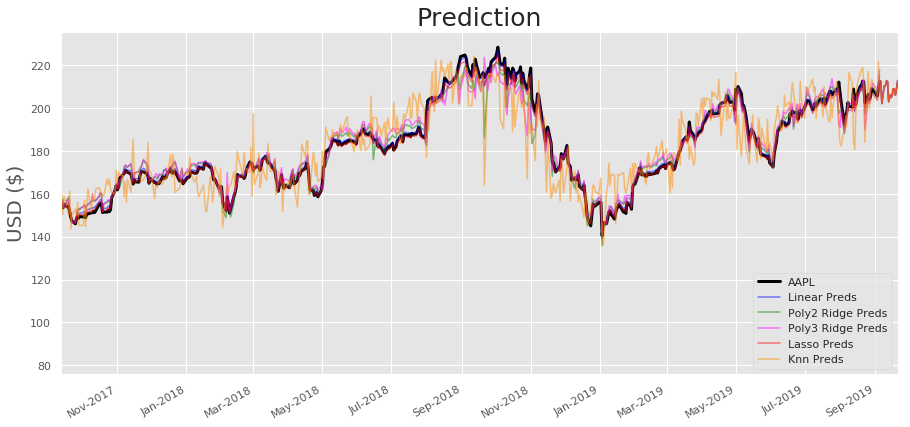

In [475]:
from matplotlib.dates import MONDAY

#recent_date = df.index.max()
display_at = 500
alpha = 0.5

# Adjusting the style of matplotlib
#style.use('ggplot')

#Create fig to plot
fig, ax = plt.subplots()

##Data
plt.plot(close_px.tail(display_at), label=name, c='black', linewidth=3)

##Real Prediction
plt.plot(df_full.index[-display_at:], linear_model_real_prediction[-display_at:], label='Linear Preds', c='blue', alpha=alpha)
plt.plot(predicted_dates, linear_model_forecast_prediction, c='blue', alpha=alpha)

plt.plot(df_full.index[display_at:], quad_poly2_ridge_model_real_prediction[display_at:], label='Poly2 Ridge Preds', c='green', alpha=alpha)
plt.plot(predicted_dates, quad_poly2_ridge_model_forecast_prediction, c='green', alpha=alpha)

plt.plot(df_full.index[display_at:], quad_poly3_ridge_model_real_prediction[display_at:], label='Poly3 Ridge Preds', c='magenta', alpha=alpha)
plt.plot(predicted_dates, quad_poly3_ridge_model_forecast_prediction, c='magenta', alpha=alpha)

plt.plot(df_full.index[display_at:], lasso_model_real_prediction[display_at:], label='Lasso Preds', c='red', alpha=alpha)
plt.plot(predicted_dates, lasso_model_forecast_prediction, c='red', alpha=alpha)

plt.plot(df_full.index[display_at:], knn_model_real_prediction[display_at:], label='Knn Preds', c='darkorange', alpha=alpha)
plt.plot(predicted_dates, knn_model_forecast_prediction, c='darkorange', alpha=alpha)

plt.legend(loc=4)
#plt.xlabel('Date', fontsize = 20)
plt.ylabel('USD ($)', fontsize = 20)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(range(1, 13), bymonthday=1, interval=2)  # every month
monthsFmt = mdates.DateFormatter("%b-%Y")
# every monday
mondays = mdates.WeekdayLocator(MONDAY)

if (display_at < 100):
  dayFmt = mdates.DateFormatter("%b,%d-%Y")
  ax.xaxis.set_major_locator(mondays)
  ax.xaxis.set_major_formatter(dayFmt)
else:
  #years_fmt = mdates.DateFormatter('%Y-%b')
  # format the ticks
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(monthsFmt)
  ax.xaxis.set_minor_locator(mondays)

# round to nearest years.
datemin = np.datetime64(dfreg.index[-display_at-forecast_out])
datemax = np.datetime64(dfreg.index.max()) + np.timedelta64(1)
ax.set_xlim(datemin, datemax)

#format the coords message box
ax.format_xdata = mdates.DateFormatter('%b,%d-%Y')
ax.set_title('Prediction', fontsize = 25)
#ax.autoscale_view()

ax.grid(True)
fig.autofmt_xdate()
plt.show()